In [2]:
import sys
sys.path.append('../../../..')
sys.path.append('../../../../lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt
import math
import lightning as L
import logging
import torch.nn.functional as F
from sklearn.decomposition import PCA


from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs,Encoder_Chairs_GPVAE, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config, LVAE_IAF, GPVAE, GPVAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.trainers.training_callbacks import WandbCallback

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling

def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0))
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

#Defining these important global variables
PROB_MISSING_DATA = 0.2
BATCH_SIZE = 256

    
%reload_ext autoreload
%autoreload 2
!nvidia-smi

Sat Sep  7 13:30:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   40C    P8             10W /   70W |     119MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# LDM

In [3]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'


data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

train_data = train_data[train_seq_mask]
eval_data = eval_data[eval_seq_mask]
test_data = test_data[test_seq_mask]

train_dataset = My_Dataset(train_data)
eval_dataset = My_Dataset(eval_data)
test_dataset = My_Dataset(test_data)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


In [4]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
new_num_channels = 3
latent_dim = new_num_channels* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=256,
per_device_eval_batch_size=256,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=25,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_Chairs(model_config)
decoder = Decoder_Chairs(model_config)
device = 'cuda'

vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder).to(device)


Latent dim: 12


## First-stage model

In [ ]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name=f"pre_training_VAE_latdim12_missing_{PROB_MISSING_DATA}", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    #callbacks=callbacks
)

In [7]:
vae.load_state_dict(torch.load('pre-trained_vae/VAE_training_2024-09-07_10-49-55/final_model/model.pt')["model_state_dict"])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


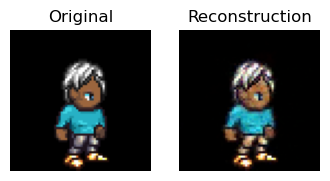

In [8]:
idx = 2556
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0))
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0))
plt.title('Reconstruction')
plt.axis('off')
plt.show()

## LDM per se

In [10]:
# Keeping only last observations

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

PROB_MISSING_DATA = 0.3
BATCH_SIZE = 256

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

#Slicing where the last observation is not missing and keeping only the last observation
train_data = train_data[train_seq_mask[:, -1] == 1, -1] 
eval_data = eval_data[eval_seq_mask[:, -1] == 1, -1]
test_data = test_data[test_seq_mask[:, -1] == 1, -1]

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


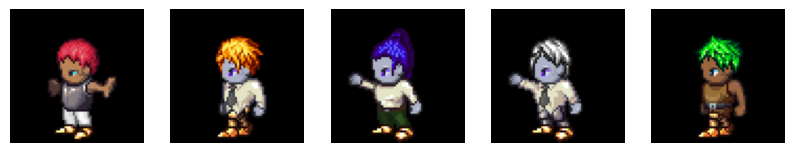

In [11]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data[i].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [12]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-09-07_10-49-55/final_model').to(device)
vae.eval()

Latent dim: 12


VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
  

In [13]:

######## UNET #######
# in_channels = 3
# out_channels = 3
# channels = 64
# n_res_blocks = 2
# attention_levels = [3]
# channel_multipliers = (1, 2, 2, 4)
# n_heads = 2

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

h, w = 64//f, 64//f


z = torch.randn(1, 3, h, w)
print("Shape of input U-NET: ", z.shape)
empty_prompt_embed = None
print("Shape of output: ", unet(z, torch.tensor([10]), empty_prompt_embed).shape)
print("Number of trainable params: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.0012


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
print("Number of trainable params (should not change): ", sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

Shape of input U-NET:  torch.Size([1, 3, 2, 2])
Shape of output:  torch.Size([1, 3, 2, 2])
Number of trainable params:  2223043
Number of trainable params (should not change):  2223043


In [ ]:
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 1e-4
BATCH_SIZE = 256
MAX_EPOCHS = 50

vae = vae.to('cuda')
latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
model = LitLDM(ldm = latent_diffusion, vae = vae, lr = lr).to('cuda')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, train_loader, val_loader)

#model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

# LLDM

In [3]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)


torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])
Loading masks...


In [4]:
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-09-07_10-49-55/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_0/checkpoints/epoch=49-step=1000.ckpt'

device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=5, device = device, addStdNorm=True)

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids
Finding temperature
Best temperature found:  2.536956787109375
Building metric
Increasing T by  5
Adding std normal to centroids and var
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [5]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.3,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
temperature = 1


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)
lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler, verbose = True, temp = temperature)
#lvae = LVAE_IAF(model_config, encoder, decoder).cuda()



#lldm.load_state_dict(torch.load('LLDM_IAF_training_0.3.pt'))
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-09-07_12-09-45/final_model/model.pt')['model_state_dict'])

Diffusion time steps  [997 831 665 499 333 167   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


<All keys matched successfully>

In [8]:
lvae = LVAE_IAF(model_config, encoder, decoder).cuda()
lvae.load_state_dict(torch.load('lldm/LVAE_IAF_training_2024-09-06_15-53-04/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

In [6]:
LR = 8*1e-4
optimizer = torch.optim.Adam(lldm.parameters(), lr=LR)
training_config = BaseTrainerConfig(
        num_epochs=50,
        learning_rate=LR,
        batch_size=BATCH_SIZE,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
trainer = BaseTrainer(
            model=lldm,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )
trainer.train()

Model passed sanity check !

Created lldm/LLDM_IAF_training_2024-09-07_13-31-59. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/50:   0%|          | 0/32 [00:00<?, ?batch/s]

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     rec_loss   reg_loss  count
0  145.668648  76.745815    4.0
1  110.495331   0.000000    5.0
2   98.460592   0.000000    4.0
3   89.701778   0.000000    6.0
4  136.426588   0.000000    4.0
5   98.883554   0.000000    7.0
6   90.988323  51.823788    2.0


Eval of epoch 1/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 109.356
Eval loss: 81.9747
--------------------------------------------------------------------------


Training of epoch 2/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  112.103943  90.075882    3.0
1   81.275879   0.000000    4.0
2   79.611330   0.000000    5.0
3   77.842518   0.000000    6.0
4   78.763552   0.000000    6.0
5   78.367239   0.000000    7.0
6   82.808856  47.008439    5.0


Eval of epoch 2/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.2544
Eval loss: 76.0149
--------------------------------------------------------------------------


Training of epoch 3/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  103.192172  93.605021    6.0
1   73.921632   0.000000    6.0
2   76.884943   0.000000    8.0
3   73.325559   0.000000    3.0
4   77.541527   0.000000    3.0
5   74.214569   0.000000    1.0
6   75.114324  30.234479    9.0


Eval of epoch 3/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.862
Eval loss: 79.9561
--------------------------------------------------------------------------


Training of epoch 4/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  114.469543  86.933599    6.0
1   77.538830   0.000000    4.0
2   79.827502   0.000000    5.0
3   76.192111   0.000000    9.0
4   75.753986   0.000000    4.0
5   78.278440   0.000000    3.0
6   78.843581  32.550285    5.0


Eval of epoch 4/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 86.926
Eval loss: 81.1261
--------------------------------------------------------------------------


Training of epoch 5/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  108.054220  81.682102    7.0
1   77.072937   0.000000    3.0
2   71.714139   0.000000    5.0
3   75.686752   0.000000    1.0
4   77.071392   0.000000    7.0
5   73.796198   0.000000    8.0
6   76.242368  26.652372    5.0


Eval of epoch 5/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.9501
Eval loss: 69.619
--------------------------------------------------------------------------


Training of epoch 6/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  97.898680  82.634314    4.0
1  68.696615   0.000000    4.0
2  68.656175   0.000000    7.0
3  67.964570   0.000000    6.0
4  72.995927   0.000000    6.0
5  68.119253   0.000000    4.0
6  72.294044  28.500326    5.0


Eval of epoch 6/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.0424
Eval loss: 67.8008
--------------------------------------------------------------------------


Training of epoch 7/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  97.257083  83.660458    7.0
1  67.617247   0.000000    8.0
2  68.775984   0.000000    5.0
3  68.068527   0.000000    3.0
4  68.706294   0.000000    7.0
5  67.066727   0.000000    3.0
6  71.322360  31.951589    3.0


Eval of epoch 7/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 79.3076
Eval loss: 91.4299
--------------------------------------------------------------------------


Training of epoch 8/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  100.356411  90.062202    4.0
1   75.788405   0.000000    6.0
2   70.177071   0.000000    4.0
3   75.794652   0.000000    6.0
4   75.776905   0.000000    7.0
5   69.922009   0.000000    2.0
6   75.406590  26.395675    7.0


Eval of epoch 8/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.0697
Eval loss: 74.0815
--------------------------------------------------------------------------


Training of epoch 9/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  115.691772  74.357147    1.0
1   79.932662   0.000000    6.0
2   71.752627   0.000000    7.0
3   68.770947   0.000000    4.0
4   71.096198   0.000000    6.0
5   72.112691   0.000000    9.0
6   76.607915  33.987347    3.0


Eval of epoch 9/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 75.9167
Eval loss: 67.2595
--------------------------------------------------------------------------


Training of epoch 10/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  108.336779  80.564098    4.0
1   77.964882   0.000000    6.0
2   72.513835   0.000000    6.0
3   70.087980   0.000000    6.0
4   71.350716   0.000000    7.0
5   72.174189   0.000000    3.0
6   80.356367  23.379117    4.0


Eval of epoch 10/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.8076
Eval loss: 72.8336
--------------------------------------------------------------------------


Training of epoch 11/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  112.384584  77.688530    4.0
1   74.998866   0.000000    8.0
2   69.804629   0.000000    3.0
3   70.631664   0.000000    5.0
4   76.441000   0.000000    5.0
5   70.910876   0.000000    8.0
6   75.258153  28.867032    3.0


Eval of epoch 11/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.7263
Eval loss: 68.8829
--------------------------------------------------------------------------


Training of epoch 12/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  106.032269  76.075342    4.0
1   69.318877   0.000000    5.0
2   69.347082   0.000000    8.0
3   67.453239   0.000000    7.0
4   71.900700   0.000000    2.0
5   67.946236   0.000000    3.0
6   73.575821  21.327985    7.0


Eval of epoch 12/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.7779
Eval loss: 73.0705
--------------------------------------------------------------------------


Training of epoch 13/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  103.013125  78.065501    3.0
1   71.704163   0.000000    6.0
2   67.985163   0.000000    3.0
3   70.016920   0.000000    5.0
4   71.404766   0.000000    4.0
5   71.045927   0.000000    9.0
6   69.946608  45.809113    6.0


Eval of epoch 13/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.0766
Eval loss: 70.8884
--------------------------------------------------------------------------


Training of epoch 14/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  94.019051  81.414402    2.0
1  64.664516   0.000000    3.0
2  62.369593   0.000000    6.0
3  63.357540   0.000000    8.0
4  71.714109   0.000000    4.0
5  62.773586   0.000000    7.0
6  64.938625  30.315553    6.0


Eval of epoch 14/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.7149
Eval loss: 62.8946
--------------------------------------------------------------------------


Training of epoch 15/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  94.953751  77.285166    4.0
1  62.237945   0.000000    8.0
2  62.959983   0.000000    5.0
3  64.009355   0.000000    5.0
4  63.610562   0.000000    8.0
5  61.965989   0.000000    3.0
6  69.563100  28.483500    3.0


Eval of epoch 15/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.3386
Eval loss: 61.9037
--------------------------------------------------------------------------


Training of epoch 16/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  91.623917  80.486722    5.0
1  61.203949   0.000000    7.0
2  59.596260   0.000000    3.0
3  59.727439   0.000000    7.0
4  63.186186   0.000000    5.0
5  59.918066   0.000000    4.0
6  63.163275  21.036232    5.0


Eval of epoch 16/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.6099
Eval loss: 61.9645
--------------------------------------------------------------------------


Training of epoch 17/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  90.984787  84.069870    1.0
1  59.840929   0.000000    4.0
2  58.853665   0.000000    7.0
3  57.343563   0.000000    8.0
4  66.413792   0.000000    4.0
5  57.182749   0.000000    3.0
6  59.893086  17.091459    9.0


Eval of epoch 17/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.5257
Eval loss: 59.0219
--------------------------------------------------------------------------


Training of epoch 18/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  88.925982  84.339195    4.0
1  62.549389   0.000000    8.0
2  62.227802   0.000000    6.0
3  59.303867   0.000000    5.0
4  61.879568   0.000000    5.0
5  57.827306   0.000000    3.0
6  65.895967  17.756732    5.0


Eval of epoch 18/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.6906
Eval loss: 78.1948
--------------------------------------------------------------------------


Training of epoch 19/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  92.587047  79.569563    5.0
1  62.119952   0.000000    5.0
2  61.256934   0.000000    6.0
3  60.905339   0.000000    5.0
4  65.123993   0.000000    3.0
5  60.657210   0.000000    5.0
6  62.880258  12.487642    7.0


Eval of epoch 19/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.2882
Eval loss: 59.2777
--------------------------------------------------------------------------


Training of epoch 20/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  90.598147  78.548033    8.0
1  59.905543   0.000000    3.0
2  58.587018   0.000000    3.0
3  58.854927   0.000000    7.0
4  62.336000   0.000000    5.0
5  58.622362   0.000000    5.0
6  62.089034  15.087519    5.0


Eval of epoch 20/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 74.4225
Eval loss: 73.225
--------------------------------------------------------------------------


Training of epoch 21/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  88.131219  82.982886    5.0
1  60.610384   0.000000    6.0
2  59.532398   0.000000    7.0
3  59.074808   0.000000    7.0
4  62.631630   0.000000    6.0
5  57.477133   0.000000    2.0
6  61.273069  15.917669    3.0


Eval of epoch 21/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.3448
Eval loss: 74.6575
--------------------------------------------------------------------------


Training of epoch 22/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  92.441942  75.528552    5.0
1  57.573065   0.000000   11.0
2  57.266987   0.000000    3.0
3  56.712706   0.000000    4.0
4  60.272150   0.000000    5.0
5  56.085037   0.000000    3.0
6  62.437019  15.199190    5.0


Eval of epoch 22/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.0446
Eval loss: 58.7842
--------------------------------------------------------------------------


Training of epoch 23/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  86.111605  80.908756    4.0
1  56.617171   0.000000    4.0
2  55.287550   0.000000    7.0
3  55.903958   0.000000    4.0
4  63.340954   0.000000    3.0
5  55.986366   0.000000    8.0
6  57.681114  11.558788    6.0


Eval of epoch 23/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.0095
Eval loss: 69.2947
--------------------------------------------------------------------------


Training of epoch 24/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  85.986027  82.148218    4.0
1  55.427216   0.000000    6.0
2  54.558402   0.000000    6.0
3  55.427728   0.000000    4.0
4  62.849876   0.000000    3.0
5  54.189760   0.000000    7.0
6  57.140851  10.280887    6.0


Eval of epoch 24/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.7561
Eval loss: 55.6445
--------------------------------------------------------------------------


Training of epoch 25/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  88.357616  83.461567    6.0
1  55.766284   0.000000    4.0
2  54.917308   0.000000    3.0
3  54.292946   0.000000    5.0
4  61.917755   0.000000    4.0
5  54.186512   0.000000    7.0
6  57.478899  12.084416    7.0


Eval of epoch 25/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.8683
Eval loss: 56.0094
--------------------------------------------------------------------------


Training of epoch 26/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  86.459969  81.139916    8.0
1  56.078186   0.000000    3.0
2  55.143159   0.000000    7.0
3  54.431795   0.000000    7.0
4  61.460573   0.000000    2.0
5  54.716029   0.000000    6.0
6  56.723357   9.915302    3.0


Eval of epoch 26/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.6234
Eval loss: 55.572
--------------------------------------------------------------------------


Training of epoch 27/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  83.364372  84.889223    4.0
1  54.535997   0.000000    9.0
2  54.239004   0.000000    7.0
3  55.575742   0.000000    5.0
4  59.516816   0.000000    5.0
5  57.146587   0.000000    2.0
6  59.791252  14.035447    4.0


Eval of epoch 27/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.4155
Eval loss: 74.0378
--------------------------------------------------------------------------


Training of epoch 28/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  89.854551  83.097967    3.0
1  55.450134   0.000000    5.0
2  54.632858   0.000000    5.0
3  54.294361   0.000000    4.0
4  60.590211   0.000000    3.0
5  54.860485   0.000000    8.0
6  57.242236  10.814591    8.0


Eval of epoch 28/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.0106
Eval loss: 86.9309
--------------------------------------------------------------------------


Training of epoch 29/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  88.306761  84.015746    5.0
1  53.829588   0.000000    2.0
2  53.506906   0.000000    4.0
3  53.851495   0.000000    8.0
4  64.432078   0.000000    3.0
5  53.568760   0.000000    7.0
6  55.937077   9.678324    7.0


Eval of epoch 29/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.0154
Eval loss: 98.9771
--------------------------------------------------------------------------


Training of epoch 30/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  88.891049  86.503217    5.0
1  53.988954   0.000000    5.0
2  53.060684   0.000000    9.0
3  53.422565   0.000000    7.0
4  61.103157   0.000000    4.0
5  53.409496   0.000000    1.0
6  56.996364  10.072136    5.0


Eval of epoch 30/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.302
Eval loss: 58.0487
--------------------------------------------------------------------------


Training of epoch 31/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  85.924971  87.652226    7.0
1  54.081062   0.000000    7.0
2  53.295426   0.000000    4.0
3  53.075845   0.000000    4.0
4  59.687997   0.000000    6.0
5  52.883050   0.000000    3.0
6  54.871331  10.038701    5.0


Eval of epoch 31/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.6123
Eval loss: 52.8541
--------------------------------------------------------------------------


Training of epoch 32/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  86.132479  84.450762    7.0
1  53.199375   0.000000    3.0
2  52.840455   0.000000    6.0
3  52.626469   0.000000    5.0
4  56.615010   0.000000    7.0
5  52.986591   0.000000    5.0
6  58.182006  12.138298    3.0


Eval of epoch 32/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.3544
Eval loss: 55.4667
--------------------------------------------------------------------------


Training of epoch 33/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  83.773933  86.004585    4.0
1  53.946018   0.000000    1.0
2  52.719029   0.000000   10.0
3  52.666595   0.000000    5.0
4  56.953908   0.000000    7.0
5  52.159299   0.000000    3.0
6  58.485935  12.667946    6.0


Eval of epoch 33/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.1805
Eval loss: 68.4304
--------------------------------------------------------------------------


Training of epoch 34/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  85.959942  82.853311    6.0
1  54.231309   0.000000    4.0
2  53.524259   0.000000    5.0
3  52.279488   0.000000    3.0
4  57.473083   0.000000    9.0
5  53.409607   0.000000    4.0
6  56.275240   9.884652    5.0


Eval of epoch 34/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.3643
Eval loss: 58.0977
--------------------------------------------------------------------------


Training of epoch 35/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  78.208527  91.086304    1.0
1  52.958155   0.000000    5.0
2  52.689449   0.000000    6.0
3  52.676641   0.000000    6.0
4  56.904194   0.000000    5.0
5  52.963209   0.000000    6.0
6  57.175573  12.163261    7.0


Eval of epoch 35/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.1938
Eval loss: 67.0102
--------------------------------------------------------------------------


Training of epoch 36/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  83.119907  87.306017    4.0
1  53.610214   0.000000    4.0
2  52.445427   0.000000    5.0
3  52.175286   0.000000    7.0
4  56.673325   0.000000    4.0
5  52.576433   0.000000    5.0
6  55.397825   9.656897    7.0


Eval of epoch 36/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.6481
Eval loss: 52.1863
--------------------------------------------------------------------------


Training of epoch 37/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  82.990779  87.585302    7.0
1  53.015429   0.000000    7.0
2  52.591137   0.000000    6.0
3  51.760914   0.000000    6.0
4  54.272378   0.000000    6.0
5  52.376242   0.000000    3.0
6  60.007526  11.758944    1.0


Eval of epoch 37/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.6137
Eval loss: 66.848
--------------------------------------------------------------------------


Training of epoch 38/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  84.211650  85.479841    6.0
1  52.871238   0.000000    7.0
2  51.843961   0.000000    5.0
3  52.340157   0.000000    2.0
4  54.557863   0.000000    7.0
5  51.887335   0.000000    4.0
6  57.268098  12.261306    5.0


Eval of epoch 38/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.1227
Eval loss: 81.1517
--------------------------------------------------------------------------


Training of epoch 39/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  82.433349  86.191001    7.0
1  52.195299   0.000000    6.0
2  52.705745   0.000000    6.0
3  52.100411   0.000000    8.0
4  56.315784   0.000000    1.0
5  51.842636   0.000000    3.0
6  55.814585  10.066392    5.0


Eval of epoch 39/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.0517
Eval loss: 54.8625
--------------------------------------------------------------------------


Training of epoch 40/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  84.577830  83.734582    6.0
1  52.445803   0.000000    5.0
2  51.477073   0.000000    4.0
3  51.443039   0.000000    4.0
4  57.744965   0.000000    8.0
5  51.900617   0.000000    5.0
6  54.232162   8.464333    4.0


Eval of epoch 40/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.4124
Eval loss: 68.1885
--------------------------------------------------------------------------


Training of epoch 41/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  83.457981  85.412296    6.0
1  52.326740   0.000000    6.0
2  51.672783   0.000000    8.0
3  51.553046   0.000000    4.0
4  56.748779   0.000000    5.0
5  51.145529   0.000000    2.0
6  54.977262  10.478392    5.0


Eval of epoch 41/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.2478
Eval loss: 68.0186
--------------------------------------------------------------------------


Training of epoch 42/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  83.723172  86.095241    5.0
1  52.643508   0.000000    3.0
2  51.650270   0.000000    4.0
3  51.484589   0.000000    5.0
4  56.348629   0.000000    7.0
5  51.787963   0.000000    4.0
6  54.952923   9.699002    8.0


Eval of epoch 42/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.3166
Eval loss: 84.6141
--------------------------------------------------------------------------


Training of epoch 43/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  83.606943  86.655675    8.0
1  52.258202   0.000000    7.0
2  51.723991   0.000000    3.0
3        NaN        NaN    0.0
4  55.845885   0.000000    6.0
5  51.269231   0.000000    4.0
6  55.592709   9.461090    8.0


Eval of epoch 43/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.5923
Eval loss: 54.2034
--------------------------------------------------------------------------


Training of epoch 44/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  82.172810  83.842720    5.0
1  52.139531   0.000000    6.0
2  51.857578   0.000000    5.0
3  51.447931   0.000000    6.0
4  55.884692   0.000000    5.0
5  51.440786   0.000000    5.0
6  54.930146   9.224392    4.0


Eval of epoch 44/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.5014
Eval loss: 67.1905
--------------------------------------------------------------------------


Training of epoch 45/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  82.858147  84.856325   10.0
1  51.767622   0.000000    5.0
2  50.984047   0.000000    4.0
3  51.467825   0.000000    2.0
4  55.922516   0.000000    6.0
5  52.265954   0.000000    4.0
6  54.700439   9.840389    5.0


Eval of epoch 45/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.155
Eval loss: 51.4155
--------------------------------------------------------------------------


Training of epoch 46/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  83.817973  84.462232    3.0
1  51.907680   0.000000    4.0
2  51.197746   0.000000    7.0
3  51.650363   0.000000    8.0
4  55.193871   0.000000    7.0
5  51.257433   0.000000    4.0
6  56.082375  10.096488    3.0


Eval of epoch 46/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.4296
Eval loss: 83.0293
--------------------------------------------------------------------------


Training of epoch 47/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  83.053743  85.654762    4.0
1  51.763899   0.000000    7.0
2  51.712523   0.000000    4.0
3  51.016337   0.000000    7.0
4  55.380590   0.000000    6.0
5  51.360938   0.000000    5.0
6  54.566408  10.322776    3.0


Eval of epoch 47/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.9773
Eval loss: 53.9165
--------------------------------------------------------------------------


Training of epoch 48/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  79.967634  86.003664    4.0
1  51.784758   0.000000    3.0
2  50.780927   0.000000    5.0
3  51.454693   0.000000    6.0
4  54.890360   0.000000   10.0
5  51.719124   0.000000    1.0
6  55.588821  10.541282    7.0


Eval of epoch 48/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.5399
Eval loss: 67.1935
--------------------------------------------------------------------------


Training of epoch 49/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  82.638050  85.853675    7.0
1  51.569541   0.000000    5.0
2  51.337185   0.000000    2.0
3  50.687088   0.000000    3.0
4  56.134853   0.000000    6.0
5  51.769586   0.000000    7.0
6  55.034931  10.104399    6.0


Eval of epoch 49/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.0676
Eval loss: 51.1879
--------------------------------------------------------------------------


Training of epoch 50/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  82.027149  85.469451    6.0
1  51.765279   0.000000    7.0
2  51.031689   0.000000    7.0
3  51.205843   0.000000    2.0
4  55.165290   0.000000    5.0
5  51.800289   0.000000    6.0
6  54.641562  10.187104    3.0


Eval of epoch 50/50:   0%|          | 0/4 [00:00<?, ?batch/s]

Saved checkpoint at epoch 50

--------------------------------------------------------------------------
Train loss: 63.2178
Eval loss: 52.3934
--------------------------------------------------------------------------
Training ended!
Saved final model in lldm/LLDM_IAF_training_2024-09-07_13-31-59/final_model


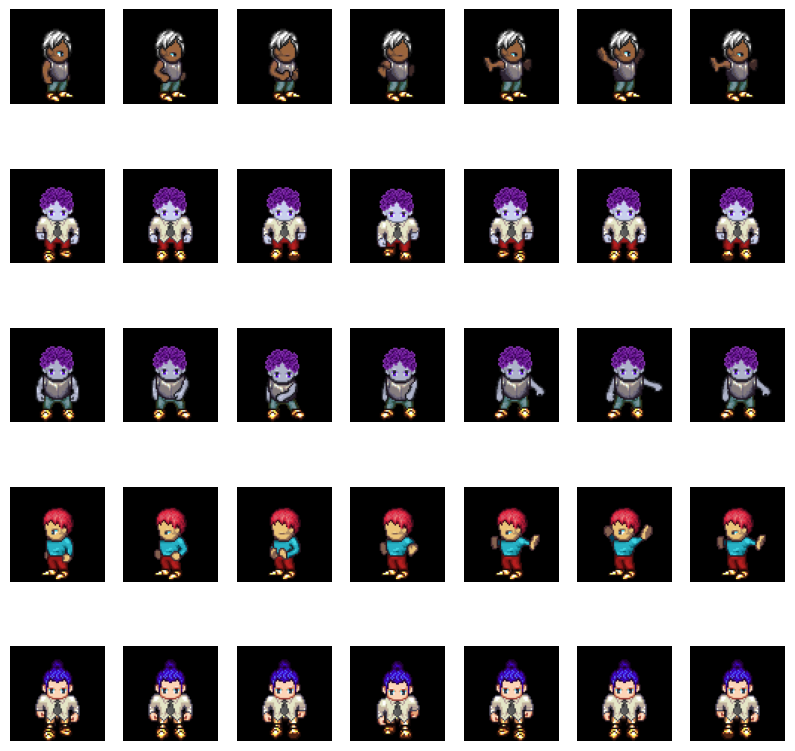

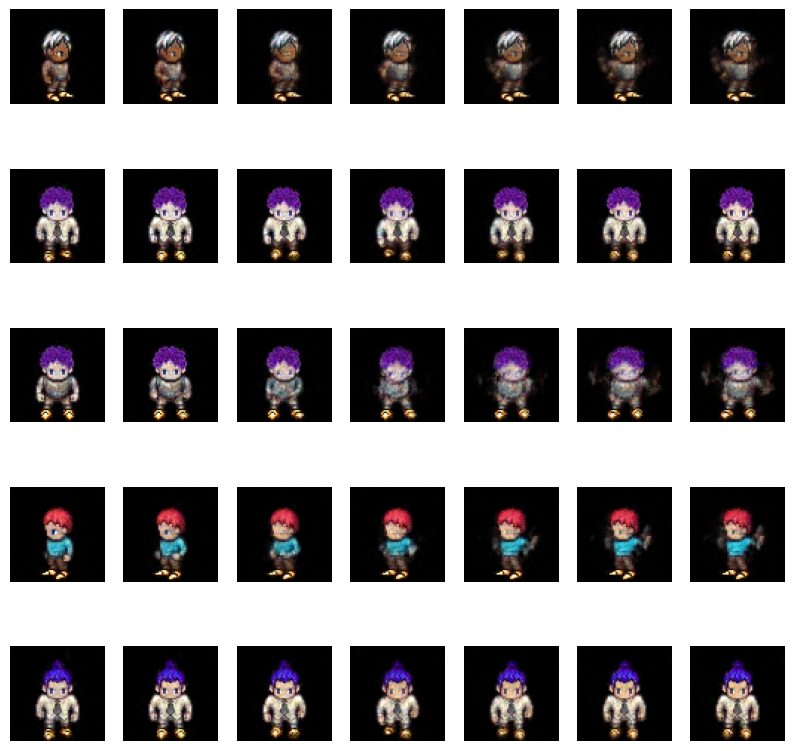

In [10]:
lldm = lldm.to('cpu')
lldm.device = 'cpu'
eval_dataset.data = eval_dataset.data.to('cpu')
_, recon_x = lldm.reconstruct(eval_dataset[5:10], vi_index=0)
plot_sequence(eval_data[5:10])
plot_sequence(recon_x.reshape(5, 7, 3, 64, 64))

In [12]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cpu')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 7, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)


torch.Size([8000, 7, 12])


PCA on the whole dataset (56000 data points)


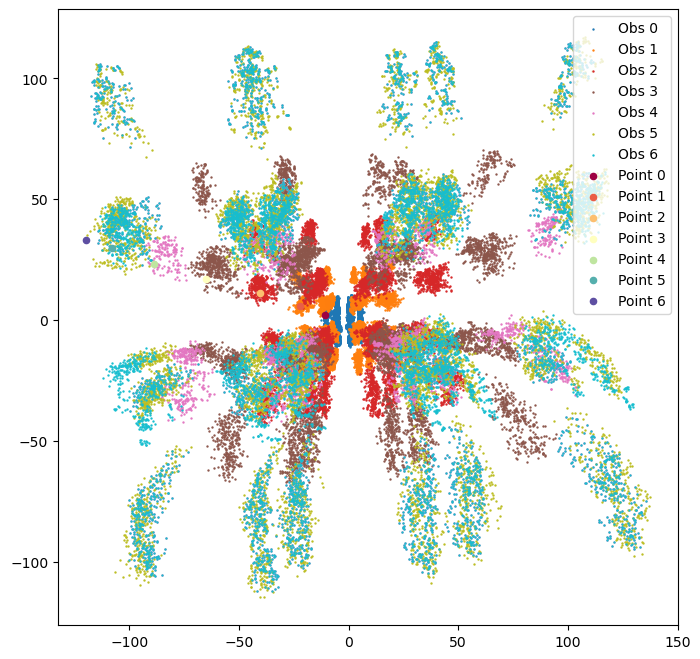

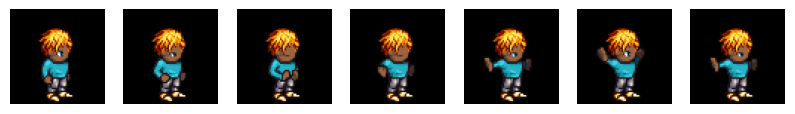

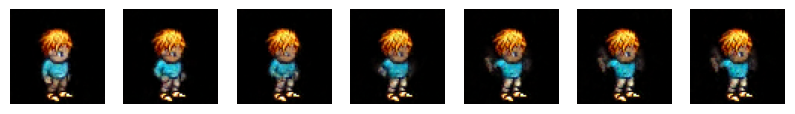

Reconstruction loss: 16.280092239379883


In [14]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
lldm = lldm.to('cpu')
#torch.manual_seed(46)

###################
vi_index = 5
projection_index = 'all' # 'all', 'pre
displayed_indexes = range(num_obs)  #range(num_obs)
train_point = 116
lldm.temperature = 1
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
elif projection_index == 'pre':
    last_preembed = torch.load('preembedding-last.pt')
    #last_preembed = torch.load('pre-embeddings2.pt')
    #last_preembed = torch.load('pre-embeddings-priordecalee.pt')
    pca.fit(last_preembed)
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)



plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]

z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

# sampler = lldm.ddim_sampler
# start = train_embeddings[train_point, vi_index, :].cuda().reshape(1, model.c, model.h, model.w)
# _, z_seq, _ = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
# z_seq = z_seq[:-1].reshape(-1, latent_dim)
# x_rec = lldm.decoder(z_seq).reconstruction


z_seq_pca = pca.transform(z_seq.cpu().detach())

colors = plt.get_cmap('Spectral', 7)
for i in range(num_obs):
    plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')


plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [15]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.3,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=10,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
lvae = LVAE_IAF(model_config, encoder, decoder).cuda()


LR = 5*1e-4
optimizer = torch.optim.Adam(lvae.parameters(), lr=LR)
training_config = BaseTrainerConfig(
        num_epochs=100,
        learning_rate=LR,
        batch_size=256,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
trainer = BaseTrainer(
            model=lvae,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )
trainer.train()

Model passed sanity check !

Created lldm/LVAE_IAF_training_2024-09-07_14-09-49. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 1/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 192.7042
Eval loss: 137.3963
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 2/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.5325
Eval loss: 120.3821
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 3/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 111.6773
Eval loss: 110.6572
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 4/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.6315
Eval loss: 98.6737
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 5/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 91.0934
Eval loss: 89.6414
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 6/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.8977
Eval loss: 82.4183
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 7/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.1414
Eval loss: 76.437
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 8/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.2065
Eval loss: 70.6685
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 9/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.5083
Eval loss: 66.7204
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 10/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.966
Eval loss: 74.9388
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 11/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.8203
Eval loss: 66.022
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 12/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.8345
Eval loss: 76.032
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 13/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 73.7659
Eval loss: 60.227
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 14/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.8526
Eval loss: 54.8864
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 15/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.8471
Eval loss: 56.8161
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 16/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.6634
Eval loss: 54.1168
--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 17/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.4766
Eval loss: 53.0659
--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 18/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.8578
Eval loss: 47.6434
--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 19/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.112
Eval loss: 49.6549
--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 20/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.8038
Eval loss: 45.3587
--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 21/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.3186
Eval loss: 44.9514
--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 22/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.1072
Eval loss: 47.0209
--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 23/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.5517
Eval loss: 47.0955
--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 24/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.1961
Eval loss: 41.2552
--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 25/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.8821
Eval loss: 40.7917
--------------------------------------------------------------------------


Training of epoch 26/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 26/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.9772
Eval loss: 42.2742
--------------------------------------------------------------------------


Training of epoch 27/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 27/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.6281
Eval loss: 38.5051
--------------------------------------------------------------------------


Training of epoch 28/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 28/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.2177
Eval loss: 38.2514
--------------------------------------------------------------------------


Training of epoch 29/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 29/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.9579
Eval loss: 36.2124
--------------------------------------------------------------------------


Training of epoch 30/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 30/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.0153
Eval loss: 44.3616
--------------------------------------------------------------------------


Training of epoch 31/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 31/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.154
Eval loss: 40.3886
--------------------------------------------------------------------------


Training of epoch 32/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 32/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.894
Eval loss: 46.9714
--------------------------------------------------------------------------


Training of epoch 33/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 33/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.1869
Eval loss: 42.327
--------------------------------------------------------------------------


Training of epoch 34/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 34/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.9477
Eval loss: 38.1394
--------------------------------------------------------------------------


Training of epoch 35/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 35/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.4466
Eval loss: 33.4364
--------------------------------------------------------------------------


Training of epoch 36/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 36/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.6535
Eval loss: 36.6655
--------------------------------------------------------------------------


Training of epoch 37/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 37/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.8507
Eval loss: 32.4953
--------------------------------------------------------------------------


Training of epoch 38/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 38/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.2246
Eval loss: 36.6049
--------------------------------------------------------------------------


Training of epoch 39/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 39/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.1837
Eval loss: 31.3349
--------------------------------------------------------------------------


Training of epoch 40/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 40/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.4029
Eval loss: 36.3407
--------------------------------------------------------------------------


Training of epoch 41/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 41/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.4576
Eval loss: 34.5864
--------------------------------------------------------------------------


Training of epoch 42/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 42/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.9517
Eval loss: 34.9874
--------------------------------------------------------------------------


Training of epoch 43/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 43/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.4469
Eval loss: 30.7136
--------------------------------------------------------------------------


Training of epoch 44/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 44/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.7776
Eval loss: 30.2841
--------------------------------------------------------------------------


Training of epoch 45/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 45/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9969
Eval loss: 30.1898
--------------------------------------------------------------------------


Training of epoch 46/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 46/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.6192
Eval loss: 29.8571
--------------------------------------------------------------------------


Training of epoch 47/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 47/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.8602
Eval loss: 37.1937
--------------------------------------------------------------------------


Training of epoch 48/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 48/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.3772
Eval loss: 29.8968
--------------------------------------------------------------------------


Training of epoch 49/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 49/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1749
Eval loss: 32.6944
--------------------------------------------------------------------------


Training of epoch 50/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 50/100:   0%|          | 0/4 [00:00<?, ?batch/s]

Saved checkpoint at epoch 50

--------------------------------------------------------------------------
Train loss: 44.1241
Eval loss: 28.6127
--------------------------------------------------------------------------


Training of epoch 51/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 51/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.3601
Eval loss: 32.5693
--------------------------------------------------------------------------


Training of epoch 52/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 52/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.7531
Eval loss: 28.5118
--------------------------------------------------------------------------


Training of epoch 53/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 53/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5043
Eval loss: 28.825
--------------------------------------------------------------------------


Training of epoch 54/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 54/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.0604
Eval loss: 30.1167
--------------------------------------------------------------------------


Training of epoch 55/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 55/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6847
Eval loss: 32.0854
--------------------------------------------------------------------------


Training of epoch 56/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 56/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9384
Eval loss: 31.4461
--------------------------------------------------------------------------


Training of epoch 57/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 57/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9618
Eval loss: 31.6256
--------------------------------------------------------------------------


Training of epoch 58/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 58/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.6844
Eval loss: 27.0909
--------------------------------------------------------------------------


Training of epoch 59/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 59/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.9223
Eval loss: 30.8735
--------------------------------------------------------------------------


Training of epoch 60/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 60/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.0093
Eval loss: 26.9144
--------------------------------------------------------------------------


Training of epoch 61/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 61/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.822
Eval loss: 26.8213
--------------------------------------------------------------------------


Training of epoch 62/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 62/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4943
Eval loss: 26.7166
--------------------------------------------------------------------------


Training of epoch 63/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 63/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.5041
Eval loss: 26.7583
--------------------------------------------------------------------------


Training of epoch 64/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 64/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1901
Eval loss: 26.3623
--------------------------------------------------------------------------


Training of epoch 65/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 65/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.9947
Eval loss: 26.4672
--------------------------------------------------------------------------


Training of epoch 66/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 66/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4304
Eval loss: 29.2568
--------------------------------------------------------------------------


Training of epoch 67/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 67/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4389
Eval loss: 29.0906
--------------------------------------------------------------------------


Training of epoch 68/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 68/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7376
Eval loss: 26.3237
--------------------------------------------------------------------------


Training of epoch 69/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 69/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.578
Eval loss: 26.1649
--------------------------------------------------------------------------


Training of epoch 70/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 70/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.4942
Eval loss: 25.8294
--------------------------------------------------------------------------


Training of epoch 71/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 71/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.2859
Eval loss: 29.2784
--------------------------------------------------------------------------


Training of epoch 72/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 72/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.6072
Eval loss: 32.4458
--------------------------------------------------------------------------


Training of epoch 73/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 73/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.2514
Eval loss: 28.6724
--------------------------------------------------------------------------


Training of epoch 74/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 74/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.7282
Eval loss: 25.4576
--------------------------------------------------------------------------


Training of epoch 75/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 75/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.3319
Eval loss: 25.2758
--------------------------------------------------------------------------


Training of epoch 76/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 76/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.8929
Eval loss: 28.4821
--------------------------------------------------------------------------


Training of epoch 77/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 77/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.4677
Eval loss: 25.36
--------------------------------------------------------------------------


Training of epoch 78/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 78/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.753
Eval loss: 25.7149
--------------------------------------------------------------------------


Training of epoch 79/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 79/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.3854
Eval loss: 25.6861
--------------------------------------------------------------------------


Training of epoch 80/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 80/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.2057
Eval loss: 24.8407
--------------------------------------------------------------------------


Training of epoch 81/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 81/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.447
Eval loss: 24.795
--------------------------------------------------------------------------


Training of epoch 82/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 82/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.0094
Eval loss: 27.5949
--------------------------------------------------------------------------


Training of epoch 83/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 83/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.8949
Eval loss: 24.8834
--------------------------------------------------------------------------


Training of epoch 84/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 84/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.7808
Eval loss: 24.4993
--------------------------------------------------------------------------


Training of epoch 85/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 85/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.5975
Eval loss: 27.8732
--------------------------------------------------------------------------


Training of epoch 86/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 86/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.8652
Eval loss: 24.4854
--------------------------------------------------------------------------


Training of epoch 87/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 87/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.8029
Eval loss: 27.4079
--------------------------------------------------------------------------


Training of epoch 88/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 88/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.5343
Eval loss: 27.1613
--------------------------------------------------------------------------


Training of epoch 89/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 89/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.5225
Eval loss: 27.7914
--------------------------------------------------------------------------


Training of epoch 90/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 90/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.6698
Eval loss: 27.8784
--------------------------------------------------------------------------


Training of epoch 91/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 91/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.7824
Eval loss: 27.2456
--------------------------------------------------------------------------


Training of epoch 92/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 92/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.7025
Eval loss: 24.1615
--------------------------------------------------------------------------


Training of epoch 93/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 93/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.1647
Eval loss: 24.0784
--------------------------------------------------------------------------


Training of epoch 94/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 94/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.5193
Eval loss: 24.0944
--------------------------------------------------------------------------


Training of epoch 95/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 95/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.3056
Eval loss: 24.1866
--------------------------------------------------------------------------


Training of epoch 96/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 96/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.8429
Eval loss: 24.2613
--------------------------------------------------------------------------


Training of epoch 97/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 97/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.5241
Eval loss: 24.0042
--------------------------------------------------------------------------


Training of epoch 98/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 98/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.5597
Eval loss: 24.1088
--------------------------------------------------------------------------


Training of epoch 99/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 99/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.8595
Eval loss: 27.5822
--------------------------------------------------------------------------


Training of epoch 100/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 100/100:   0%|          | 0/4 [00:00<?, ?batch/s]

Saved checkpoint at epoch 100

--------------------------------------------------------------------------
Train loss: 38.7905
Eval loss: 27.2198
--------------------------------------------------------------------------
Training ended!
Saved final model in lldm/LVAE_IAF_training_2024-09-07_14-09-49/final_model


In [ ]:
input_dim = (3, 64, 64)
latent_dim = 12
beta = 1
n_hidden_in_made = 3
n_made_blocks = 2
warmup = 5
context_dim = None
prior = 'standard'
posterior = 'gaussian'
vamp_number_components= 500
linear_scheduling_steps = 10
num_epochs = 150
batch_size = 256
learning_rate=  1e-3 
steps_saving = 50
steps_predict = 100
shuffle_data = True
kernel = "cauchy"
out_channels_time_cnn = 265




config = GPVAEConfig(
    input_dim=input_dim,
    time_length=train_data.shape[1],
    kernel_choice=kernel,
    kernel_scales=1,
    latent_dim=latent_dim,
    sigma=1,
    length_scale=1,
    beta=beta,
    out_channels_time_cnn=out_channels_time_cnn
)

training_config = BaseTrainerConfig(
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        batch_size=batch_size,
        steps_saving=steps_saving,
        steps_predict=steps_predict,
        shuffle=shuffle_data
    )

encoder = Encoder_Chairs_GPVAE(config)
decoder = Decoder_Chairs(config)

#model = LVAE_IAF(config, encoder, decoder).to('cuda')
model = GPVAE(config, encoder, decoder).cuda()

### Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[50, 100, 125, 150],
    gamma=0.5,
    verbose=True
)

trainer = BaseTrainer(
            model=model,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
        )

trainer.train()

In [17]:
model = model.to('cuda')
model.eval()

from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

mses = []
for i, x in tqdm(enumerate(test_loader)):
    x.data = x.data.to('cuda')
    x.seq_mask = x.seq_mask.to('cuda')
    x.pix_mask = x.pix_mask.to('cuda')
    recon_x = model(x).recon_x.cpu().detach()
    mse = F.mse_loss(recon_x, x.data.cpu().detach(), reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()
    mses.append(mse)

mses = torch.cat(mses)
print('MSE:', mses.mean().item())



84it [00:01, 47.41it/s]

MSE: 0.009317790158092976


In [18]:
from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

rec_losses_lvae, rec_losses_lldm = [], []
lvae = lvae.to('cpu')
lvae.eval()

lldm = lldm.to('cpu')
lldm.device = 'cpu'
lldm.eval()
for i, x in tqdm(enumerate(test_loader)):
    _, x_rec_lvae = lvae.reconstruct(x, vi_index=1, device = 'cpu')
    x_rec_lvae = x_rec_lvae.reshape(-1, 7, 3, 64, 64)
    _, x_rec_lldm = lldm.reconstruct(x, vi_index=2)
    x_rec_lldm = x_rec_lldm.reshape(-1, 7, 3, 64, 64)

    rec_loss_lvae = F.mse_loss(x_rec_lvae.cpu(), x.data, reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()
    rec_loss_lldm = F.mse_loss(x_rec_lldm.cpu(), x.data, reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()

    rec_losses_lvae.append(rec_loss_lvae)
    rec_losses_lldm.append(rec_loss_lldm)

lvae_loss = torch.cat(rec_losses_lvae).mean().item()
lldm_loss = torch.cat(rec_losses_lldm).mean().item()

print('LVAE loss:', lvae_loss)
print('LLDM loss:', lldm_loss)

84it [00:18,  4.49it/s]

LVAE loss: 0.0035474912729114294
LLDM loss: 0.0041799829341471195
